In [1]:
##https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

In [25]:
import theano
import pymc3 as pm
import sklearn
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [26]:
X,Y = make_moons(noise = 0.2,random_state = 0,n_samples =1000)

In [27]:
X =scale(X)

In [28]:
X =X.astype(float)
Y = Y.astype(float)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.5)
print (X.shape)

(1000, 2)


[Text(0,0.5,'Y'),
 Text(0.5,0,'X'),
 Text(0.5,1,'Toy binary classification data set')]

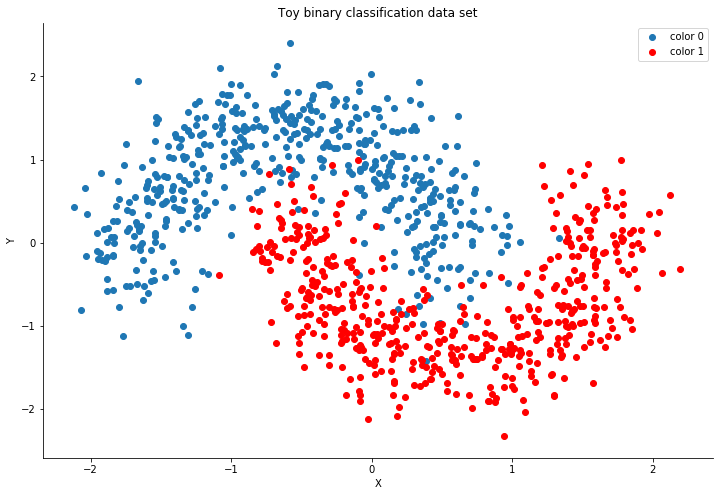

In [29]:
## ploting the graph 
fig, ax = plt.subplots(figsize =(12,8))
ax.scatter(X[Y==0,0],X[Y==0,1],label="color 0")
ax.scatter(X[Y==1,0],X[Y==1,1],color= 'r',label="color 1")
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set')


In [30]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [31]:
## using ADVI variational inference library
## https://arxiv.org/abs/1603.00788
## Note, that this is a mean-field approximation so we ignore correlations in the posterior.

from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [ ]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000,method=inference )

Average Loss = 161.84:  54%|██████████████████▌               | 27222/50000 [1:28:42<1:14:13,  5.11it/s]

In [ ]:
trace = approx.sample(draws=5000)## sampling from given posterior distribution

In [ ]:
## plotting the elbo 

plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [ ]:
## predicting the valuue with posterior predictive check 
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace,samples =500, progressbar = False)
    
pred = ppc["out"].mean(axis=0)>0.5

In [ ]:
fig, ax = plt.subplots(figsize =(12,8))
ax.scatter(X_test[pred==0,0],X_test[pred==0,1],label="color 0")
ax.scatter(X_test[pred==1,0],X_test[pred==1,1],color= 'r',label="color 1")
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='predicting the label for test set.')


In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

In [ ]:
cmap = sns.diverging_palette(250,12,s=18,l=25,as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');